In [11]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.2 MB/s eta 0:00:00


## Data Loading

In [1]:
import kagglehub
# Download Arabic Data
path = kagglehub.dataset_download("mksaad/arabic-sentiment-twitter-corpus")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/arabic-sentiment-twitter-corpus


In [ ]:
!mkdir /content/Data
!cp -r /root/.cache/kagglehub/datasets/mksaad/arabic-sentiment-twitter-corpus/versions/2 /content/Data

mkdir: cannot create directory ‘/content/Data’: File exists


In [2]:
import pandas as pd
import numpy as np

pos_train = pd.read_csv('//kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_positive_20190413.tsv',sep='\t',encoding='utf-8',names = ["label", "text"])
pos_test = pd.read_csv('/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_positive_20190413.tsv',sep='\t',encoding='utf-8',names = ["label", "text"])

neg_train = pd.read_csv('/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_negative_20190413.tsv',sep='\t',encoding='utf-8',names = ["label", "text"])
neg_test = pd.read_csv('/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_negative_20190413.tsv',sep='\t',encoding='utf-8',names = ["label", "text"])

train = pd.concat([pos_train,neg_train])
test = pd.concat([pos_test,neg_test])

## Data Exploration

In [3]:
train

,label,text
0,pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...
1,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
2,pos,من الخير نفسه 💛
3,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...
4,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...
...,...,...
22509,neg,كيف ترى أورانوس لو كان يقع مكان القمر ؟ 💙💙 كوك...
22510,neg,احسدك على الايم 💔
22511,neg,لأول مرة ما بنكون سوا 💔
22512,neg,بقله ليش يا واطي 🤔


exploring class Balance

/tmp/ipython-input-23-1815240479.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, palette='Blues', ax=axes[0])
/tmp/ipython-input-23-1815240479.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index, y=test_counts.values, palette='Oranges', ax=axes[1])
/tmp/ipython-input-23-1815240479.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-23-1815240479.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

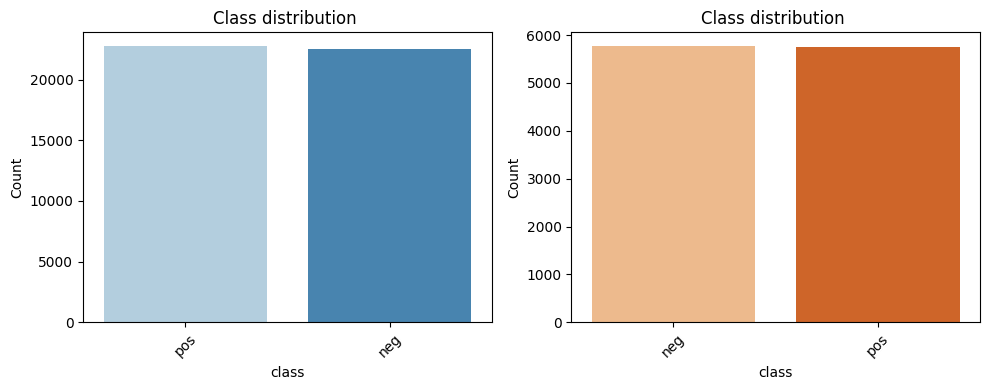

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count labels in both sets
train_counts = train['label'].value_counts()
test_counts = test['label'].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot training distribution
sns.barplot(x=train_counts.index, y=train_counts.values, palette='Blues', ax=axes[0])
axes[0].set_title("Class distribution ")
axes[0].set_xlabel("class")
axes[0].set_ylabel("Count")

# Plot testing distribution
sns.barplot(x=test_counts.index, y=test_counts.values, palette='Oranges', ax=axes[1])
axes[1].set_title("Class distribution ")
axes[1].set_xlabel("class")
axes[1].set_ylabel("Count")

# Rotate x-axis labels if needed
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


Data is obviously balanced and we will work on it as it is

## Build data Pipeline

In [18]:
import pandas as pd
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

nltk.download('stopwords')# Define stopwords
arabic_stopwords = set(stopwords.words('arabic'))
custom_stopwords = set(['مثلا', 'يعني'])
all_stopwords = arabic_stopwords.union(custom_stopwords)
number_map = {
                      '٠': 'صفر',
                      '١': 'واحد',
                      '٢': 'اثنان',
                      '٣': 'ثلاثة',
                      '٤': 'أربعة',
                      '٥': 'خمسة',
                      '٦': 'ستة',
                      '٧': 'سبعة',
                      '٨': 'ثمانية',
                      '٩': 'تسعة',
                      '0': 'صفر',
                      '1': 'واحد',
                      '2': 'اثنان',
                      '3': 'ثلاثة',
                      '4': 'أربعة',
                      '5': 'خمسة',
                      '6': 'ستة',
                      '7': 'سبعة',
                      '8': 'ثمانية',
                      '9': 'تسعة'
                  }
# Define normalization
def normalize_arabic(text):
    text = re.sub('[إأآٱا]', 'ا', text)
    text = re.sub('[ىٰ]', 'ي', text)
    text = re.sub('[ؤئ]', 'ء', text)
    text = re.sub('ة', 'ه', text)
    return text

# Remove punctuation (but keep emoji tokens)
def remove_unwanted_punct(text):
    return re.sub(r'[^\w\s\u0600-\u06FF:_]', '', text)

# Clean + preprocess + stem
class ArabicPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, apply_stemming=False):
        self.apply_stemming = apply_stemming
        self.stemmer = ISRIStemmer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess)

    def _preprocess(self, text):
        text = str(text)
        text = emoji.demojize(text)
        for arabic, name in number_map.items():
            text = text.replace(arabic, name)
        text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
        text = normalize_arabic(text)
        text = remove_unwanted_punct(text)
        text = re.sub(r'(.)\1+', r'\1', text)
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize and remove stopwords
        tokens = [w for w in text.split() if w not in all_stopwords]

        # Optional stemming
        if self.apply_stemming:
            tokens = [self.stemmer.stem(w) for w in tokens]

        return ' '.join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Run pipeline and evaluation

Accuracy: 0.942
              precision    recall  f1-score   support

         neg      0.948     0.935     0.941      5768
         pos      0.936     0.949     0.942      5752

    accuracy                          0.942     11520
   macro avg      0.942     0.942     0.942     11520
weighted avg      0.942     0.942     0.942     11520



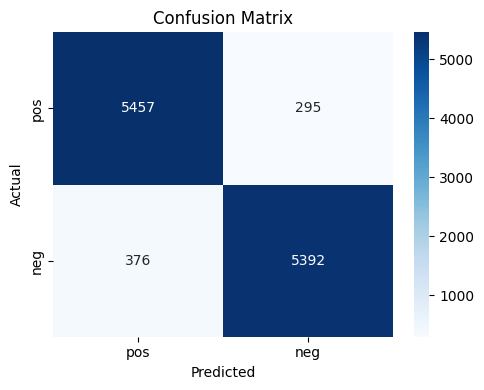

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Build pipeline
pipeline = Pipeline([
    ('preprocess', ArabicPreprocessor(apply_stemming=True)),
    ('vectorizer', CountVectorizer(ngram_range=(1,2))),        # unigrams + bigrams
    ('classifier', LogisticRegression(max_iter=1000))
])
X_train=train['text']
y_train=train['label']
X_test=test['text']
y_test=test['label']
# Train
pipeline.fit(X_train, y_train)

# Evaluate

y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred, labels=['pos','neg'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()